In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

data = pd.read_csv('firstsemester/BostonHousing.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [10]:
'''
We're trying to predict the median value (MEDV) of owner-occupied homes (in $1000s) in Boston suburbs based on various features such as crime rate, number of rooms, accessibility to highways, etc. Earlier, we saw how to do this with regression, which is far more rudimentary. Now we'll implement a simple neural network to perform the same task. I'm expecting better performance from this, given the complexity of neural networks.
'''

"\nWe're trying to predict the median value (MEDV) of owner-occupied homes (in $1000s) in Boston suburbs based on various features such as crime rate, number of rooms, accessibility to highways, etc. Earlier, we saw how to do this with regression, which is far more rudimentary. Now we'll implement a simple neural network to perform the same task. I'm expecting better performance from this, given the complexity of neural networks.\n"

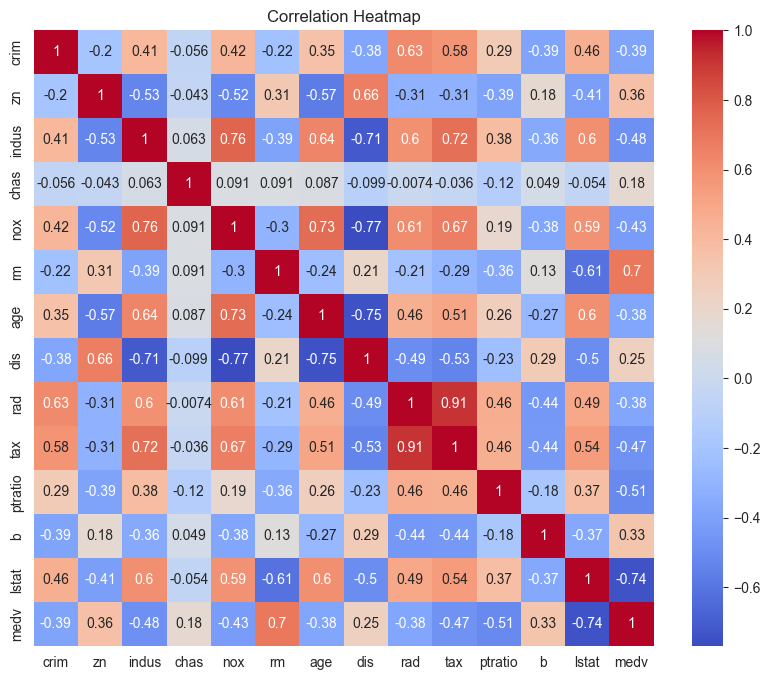

In [11]:
import seaborn as sns
# heatmap of corrs
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# let's figure out which features correlate best with the median value of homes. We use a heatmap to visualize these correlations. I decided to go with all the positively correlated features for this model. Keep in mind that more features don't always mean a better model-some features can actively confuse a model.

In [12]:
# using features zn rm dis b lstat to predict medv
features = data[['zn', 'rm', 'dis', 'b', 'lstat', 'ptratio', 'indus', 'nox', 'crim']].values
# these are the features that I saw had a positive correlation with medv in the heatmap (We added more features this time to improve model performance and also we added negative correlations to see if the model can learn complex relationships)
target = data['medv'].values

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42) # let's set aside 20% of our data for testing, so we can make sure the model isn't overfitting/underfitting

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# I only scale the features, not the target variable. This is because the target variable represents the actual values we want to predict, and scaling it could distort the interpretation of the model's output. We'll look into more advanced techniques later to handle normalization, usually at the level of each layer/batch instead of the outputs.

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)
# converting to tensors - neural networks use tensors, a type of multi-dimensional array, to perform calculations efficiently
# PyTorch especially likes sending tensors to the GPU for faster computation, and the GPU is really good at doing small arithmetic operations in parallel. Tensors make it easy to handle, because they're essentially matrices, and linear algebra operations on matrices are basically just simple arithmetic.

In [14]:
torch.manual_seed(42)  # for reproducibility

class NeuralNet(nn.Module):
    def __init__(self,):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(9, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
    # I'm creating 3 fully connected layers (each neuron in one layer is connected to every neuron in the next layer) with ReLU activation functions in between. The input layer has 10 neurons (one for each feature), and the output layer has 1 neuron (for the predicted median value). I also added batch normalization and dropout layers to improve training stability and reduce overfitting.

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        return out

model = NeuralNet()
print(model)

NeuralNet(
  (fc1): Linear(in_features=9, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [15]:
criterion = nn.MSELoss() # mean squared error loss for regression, which penalizes larger errors more heavily while also eliminating all negative values
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# We're using the Adam optimizer, which is an adaptive learning rate optimization algorithm that has been shown to work well. If we continue our metaphor of gradient descent as hiking down a mountain, Adam replaces the hiker with a ball with momentum. This ball can get over small bumps and hills using its momentum, not getting stuck in local minima. Adam also has an "adaptive learning rate," meaning it adjusts how big of a step it takes based on the terrain. If the terrain is steep, it takes smaller steps to avoid overshooting; if it's flat, it can take larger steps to speed up progress.

for epoch in range(1500): # we're running for 1500 epochs (Less than last time to avoid overfitting). one forward and backward pass over the entire dataset is one epoch
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad() # let's reset the gradients to zero before backpropagation, because PyTorch accumulates gradients by default (bit annoying but it's one line of code to fix)
    loss.backward() # backpropagation - calculating the gradients (refer to the neuralnets.md file for lecture notes on this topic)
    optimizer.step() # updating the weights based on the gradients calculated during backpropagation
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{1500}], Loss: {loss.item():.4f}') # to keep track of the model, I print the loss every 100 epochs

Epoch [100/1500], Loss: 517.7068
Epoch [200/1500], Loss: 446.7923
Epoch [300/1500], Loss: 357.5654
Epoch [400/1500], Loss: 269.2056
Epoch [500/1500], Loss: 182.0683
Epoch [600/1500], Loss: 117.7404
Epoch [700/1500], Loss: 71.3399
Epoch [800/1500], Loss: 46.3940
Epoch [900/1500], Loss: 31.1723
Epoch [1000/1500], Loss: 23.6041
Epoch [1100/1500], Loss: 22.8331
Epoch [1200/1500], Loss: 20.3976
Epoch [1300/1500], Loss: 23.5859
Epoch [1400/1500], Loss: 20.0145
Epoch [1500/1500], Loss: 20.3261


Test MSE Loss: 11.7058


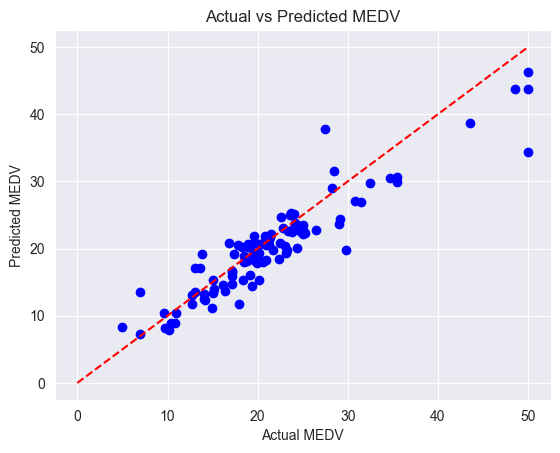

In [16]:
model.eval()
with torch.no_grad(): # disabling gradient calculation when we're using the model, because the model is already trained and good to go.
    predicted = model(X_test_tensor) # pass in the input tensor, get out the output tensor
    test_loss = criterion(predicted, y_test_tensor) # testing predicted against actual, and reporting the Mean Squared Error loss
    print(f'Test MSE Loss: {test_loss.item():.4f}')

plt.scatter(y_test, predicted.numpy(), color='blue')
plt.plot([0, 50], [0, 50], color='red', linestyle='--')
plt.xlabel('Actual MEDV')
plt.ylabel('Predicted MEDV')
plt.title('Actual vs Predicted MEDV')
plt.show()
# I'm doing a general plot about how well the model performed. The closer the blue dots are to the red dashed line, the better the model performed. The red dashed line represents perfect predictions, where the predicted values exactly match the actual values at a y=x relation. You'll notice outliers, which are points that are far away from the red dashed line. These indicate instances where the model's predictions were significantly off from the actual values. Outliers can occur for various reasons, such as unusual data points that don't follow the general trend, or limitations in the model's ability to capture complex patterns in the data. Identifying and analyzing these outliers can provide insights into potential areas for model improvement or data quality issues. 

# This model has many issues, the least of which is that it was built in 15 minutes. This model is (in the grand scheme of things) quite simple, and there are many ways to improve it. For one, the model only has four features (unfortunate limitation of our dataset and how poorly some of the features correlated with the median value) and only 3232 parameters (weights that can be adjusted). In practice, neural networks often have millions of parameters and hundreds of features. 

# Additionally, techniques like dropout can reduce overfitting by disconnecting certain neurons/nodes in the network. Batch normalization can help stabilize and speed up training by normalizing the inputs to each layer. These techniques, along with hyperparameter tuning (adjusting learning rates, number of layers, number of neurons per layer, etc.) can significantly improve model performance. We'll look into these techniques next week. See you there!